# **Análise da Geração Distribuída no Brasil**
<font size="5">**Data Visualization**</font>    
    
---
<p style='text-align: right;'> Por Henrique Leão </p> 

##  **1. Considerações Iniciais**

O presente Notebook tem como finalidade apresentar gráficamente os dados provenientes dos Scripts '1_Manipulando_Dados.py' e '2_Criando_DataFrames', dessa forma dando andamento ao estudo ao qual o projeto se propõe.

Essa parte do estudo contém:

* <font color=blue> Em desenvolvimento </font>
* <font color=blue> Em desenvolvimento </font>
* <font color=blue> Em desenvolvimento </font>

**Considerações:** 
    
1. O período análisado gráficamente tem inicio em 2012, coincidindo com a REN 482/2012.
    
2. Apesar da existência de dados anteriores a 2012 os mesmos tem baixa represetatividade para o estudo devido a sua proporção.

In [1]:
import pandas as pd
import numpy as np
#import matplotlib.dates as mdates
#import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px

#import matplotlib.dates as mdates
#import matplotlib.cbook as cbook

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_Base = pd.read_csv('../Output/DataFrame_Base.csv', sep = ';', encoding = 'utf-8')
df_Base['Data_Conexao'] = pd.to_datetime(df_Base['Data_Conexao'], format='%Y/%m/%d')

df_Tarifas = pd.read_csv('../Output/DataFrame_Tarifas.csv', sep = ';')
df_Tarifas['Data_Referencia'] = pd.to_datetime(df_Tarifas['Data_Referencia'], format='%Y/%m/%d')

##  **2. Funções**

In [29]:
def Total_Mini_Micro(Parametro, Parametro_Opcional_1 = 0, Parametro_Opcional_2 = 0, Filtro = 'index == index'):
    if Parametro_Opcional_1 == 0 and Parametro_Opcional_2 == 0:
        # Listando as colunas de interesse
        df_Mini_Micro = [df_Base.query(Filtro)[Parametro], df_Base.query(Filtro)['Pot_Instalada_kW']]
        df_Mini_Micro = pd.concat(df_Mini_Micro, axis = 1)

        # Agrupando pela contagem da quantidade e soma dos valores de potência
        df_Mini_Micro = pd.concat([df_Mini_Micro.groupby([Parametro]).count(), 
            df_Mini_Micro.groupby([Parametro]).sum()],
            axis = 1).reset_index()

        df_Mini_Micro.columns = [Parametro, 'Unidades_Conectadas', 'Pot_Instalada_kW']
        
    elif Parametro_Opcional_1 != 0 and Parametro_Opcional_2 == 0:
    
        df_Mini_Micro = [df_Base.query(Filtro)[Parametro], df_Base.query(Filtro)[Parametro_Opcional_1], 
            df_Base.query(Filtro)['Pot_Instalada_kW']]
        df_Mini_Micro = pd.concat(df_Mini_Micro, axis = 1)

        # Agrupando pela contagem da quantidade e soma dos valores de potência
        df_Mini_Micro = pd.concat([df_Mini_Micro.groupby([Parametro, Parametro_Opcional_1]).count(), 
            df_Mini_Micro.groupby([Parametro, Parametro_Opcional_1]).sum()],
            axis = 1).reset_index()

        df_Mini_Micro.columns = [Parametro, Parametro_Opcional_1, 'Unidades_Conectadas', 'Pot_Instalada_kW']

    elif Parametro_Opcional_1 != 0 and Parametro_Opcional_2 != 0:
        df_Mini_Micro = [df_Base.query(Filtro)[Parametro], df_Base.query(Filtro)[Parametro_Opcional_1], 
            df_Base.query(Filtro)[Parametro_Opcional_2], df_Base.query(Filtro)['Pot_Instalada_kW']]
        df_Mini_Micro = pd.concat(df_Mini_Micro, axis = 1)

        # Agrupando pela contagem da quantidade e soma dos valores de potência
        df_Mini_Micro = pd.concat([df_Mini_Micro.groupby([Parametro, Parametro_Opcional_1, Parametro_Opcional_2]).count(), 
            df_Mini_Micro.groupby([Parametro, Parametro_Opcional_1, Parametro_Opcional_2]).sum()],
            axis = 1).reset_index()

        df_Mini_Micro.columns = [Parametro, Parametro_Opcional_1, Parametro_Opcional_2, 'Unidades_Conectadas', 'Pot_Instalada_kW']

    # Arredondando a coluna 'Pot_Instalada_kW' para 2 casas decimais
    df_Mini_Micro['Pot_Instalada_kW'] = df_Mini_Micro.Pot_Instalada_kW.apply(lambda x: round(x, 2))
    # Adicionando coluna de potência média por unidade
    df_Mini_Micro['Pot_Media_por_Unidade'] = (df_Mini_Micro.Pot_Instalada_kW / df_Mini_Micro.Unidades_Conectadas).round(2)
    df_Mini_Micro.index = range(df_Mini_Micro.shape[0])
    
    return df_Mini_Micro

def Frequencia_Relativa(Parametro):
    index = np.sort(df_Base.Data_Conexao.dt.year.unique())
    df_empty = pd.DataFrame(index = index)
    # Criando lista com valores unicos do parametro
    lista = np.sort(df_Base[Parametro].unique())
    saida = []

    for i in range(len(lista)):
        iterador = lista[i]
        filtro = f'{Parametro} ==@ iterador'
        # Definindo a quantidade de conexões por ano para elemento do parametro
        x = pd.DataFrame(df_Base.query(filtro).groupby([df_Base.Data_Conexao.dt.year]).size())
        # Distribuindo em um index fixo para não pular ano em nenhum caso
        x = pd.concat([df_empty, x], axis=1)
        # Corrigindo NaN dos espaços criados por 0
        x = x.fillna(0).astype(int)
        # Transformando o index em uma nova coluna
        x.reset_index(level=0, inplace=True)
        # Renomeando colunas
        x.columns = ['Ano', 'Novas_Conexoes']
        # Inserindo a Classe de Fornecimento de referencia
        x[Parametro] = iterador
        # Criando coluna de valor acumulado por ano
        x['Acumulado'] = x.Novas_Conexoes.cumsum()
        # Reordenando as colunas do DataFrame
        x = x[['Ano', Parametro, 'Novas_Conexoes', 'Acumulado']]
        # Salvando ações da primeira interação antes do inicio da nova
        saida.append(x)
    
    # Concatenando os DataFrames criados no loop em um único
    Concatenar = pd.concat(saida)
    # Criando lista com valores unicos de anos
    Periodo = np.sort(Concatenar.Ano.unique())
    saida = []

    for i in range(len(Periodo)):
        iterador = Periodo[i]
        # Selecionando informações com base no ano
        x = Concatenar.query('Ano ==@ iterador')
        # Calculando a Frequencia Relativa para cada elemento do parametro por ano
        x['Freq_Novas[%]'] = ((x.Novas_Conexoes * 100) / (x.Novas_Conexoes.sum())).round(2)
        x['Freq_Acumulado[%]'] = ((x.Acumulado * 100) / (x.Acumulado.sum())).round(2)
        # Rordenando colunas
        x = x[['Ano', Parametro, 'Novas_Conexoes', 'Freq_Novas[%]', 'Acumulado', 'Freq_Acumulado[%]']]
        # Salvando ações da primeira interação antes do inicio da nova
        saida.append(x)

    # Concatenando os DataFrames criados no loop em um único
    DataFrame = pd.concat(saida).reset_index(drop = True)
    DataFrame = DataFrame.sort_values(by= ['Ano'])
    DataFrame
    return DataFrame

def Mediana_Pot(Parametro):
      mediana = df_Base.query('Data_Conexao.dt.year >= 2012 and Pot_Instalada_kW <= 75 and Tipo_Geracao == "UFV" and Classe_Consumo == @Parametro').Pot_Instalada_kW.median()
      return mediana

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

##  **3. Visualização dos Dados**

###  **3.1. Total de Conexões**

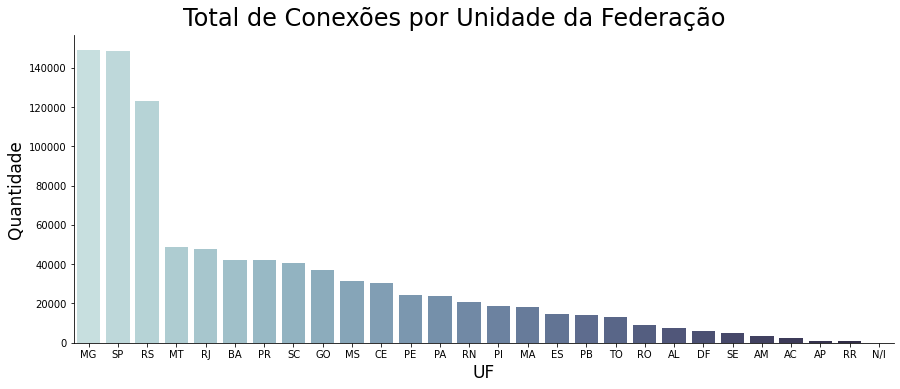

In [4]:
Grafico = sns.catplot(x = 'UF', kind = 'count', 
            data = df_Base.query('2012 <= Data_Conexao.dt.year <= 2022'), 
            aspect = 2.5, 
            palette = 'ch:start=.2,rot=-.3',
            order = df_Base.UF.value_counts().index)

Grafico.fig.suptitle('Total de Conexões por Unidade da Federação', y = 1.05, fontsize = 24)
Grafico.set_xlabels('UF', fontsize = 17)
Grafico.set_ylabels('Quantidade', fontsize = 17)

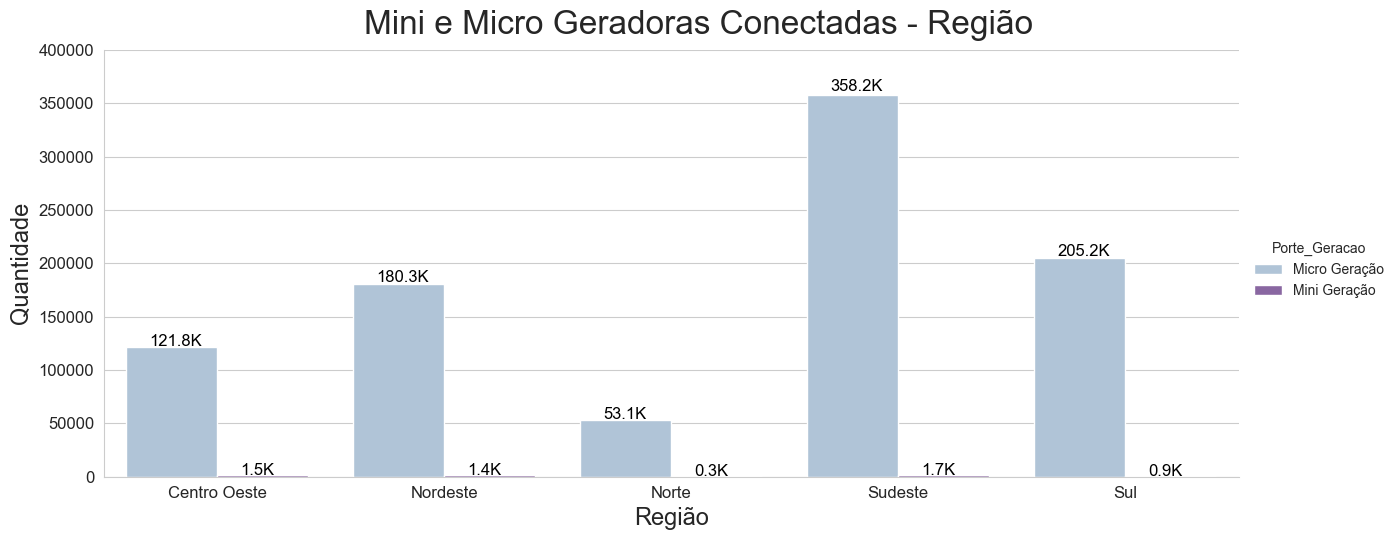

In [59]:
DataFrame = Total_Mini_Micro(Parametro = 'Regiao', Parametro_Opcional_1 = 'Porte_Geracao')

Grafico = sns.catplot(x = 'Regiao', y = 'Unidades_Conectadas', hue = 'Porte_Geracao', kind = 'bar', 
            data = DataFrame, 
            aspect = 2.5, 
            palette = 'BuPu')

Grafico.fig.suptitle('Mini e Micro Geradoras Conectadas - Região', y = 1.05, fontsize = 24)
Grafico.set_xlabels('Região', fontsize = 17)
Grafico.set_xticklabels(size=12)
Grafico.set_ylabels('Quantidade', fontsize = 17)
Grafico.set_yticklabels(size=12)

ax = Grafico.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() +  + 0.1, 
    p.get_height() * 1.01, 
    '{0:.1f}K'.format(p.get_height()/1000),
    color='black', 
    rotation='horizontal', 
    size='large')


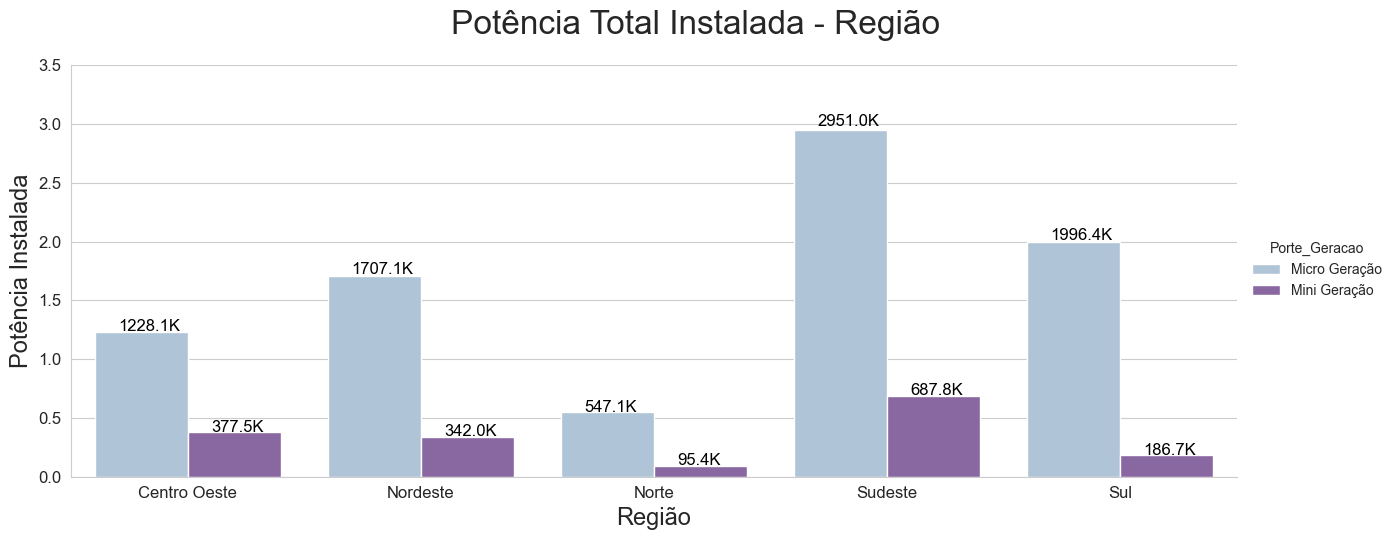

In [60]:
DataFrame = Total_Mini_Micro(Parametro = 'Regiao', Parametro_Opcional_1 = 'Porte_Geracao')

Grafico = sns.catplot(x = 'Regiao', y = 'Pot_Instalada_kW', hue = 'Porte_Geracao', kind = 'bar', 
            data = DataFrame, 
            aspect = 2.5, 
            palette = 'BuPu')

Grafico.fig.suptitle('Potência Total Instalada - Região', y = 1.05, fontsize = 24)
Grafico.set_xlabels('Região', fontsize = 17)
Grafico.set_xticklabels(size=12)
Grafico.set_ylabels('Potência Instalada', fontsize = 17)
Grafico.set_yticklabels(size=12)

ax = Grafico.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() +  + 0.1, 
    p.get_height() * 1.01, 
    '{0:.1f}K'.format(p.get_height()/1000),
    color='black', 
    rotation='horizontal', 
    size='large')

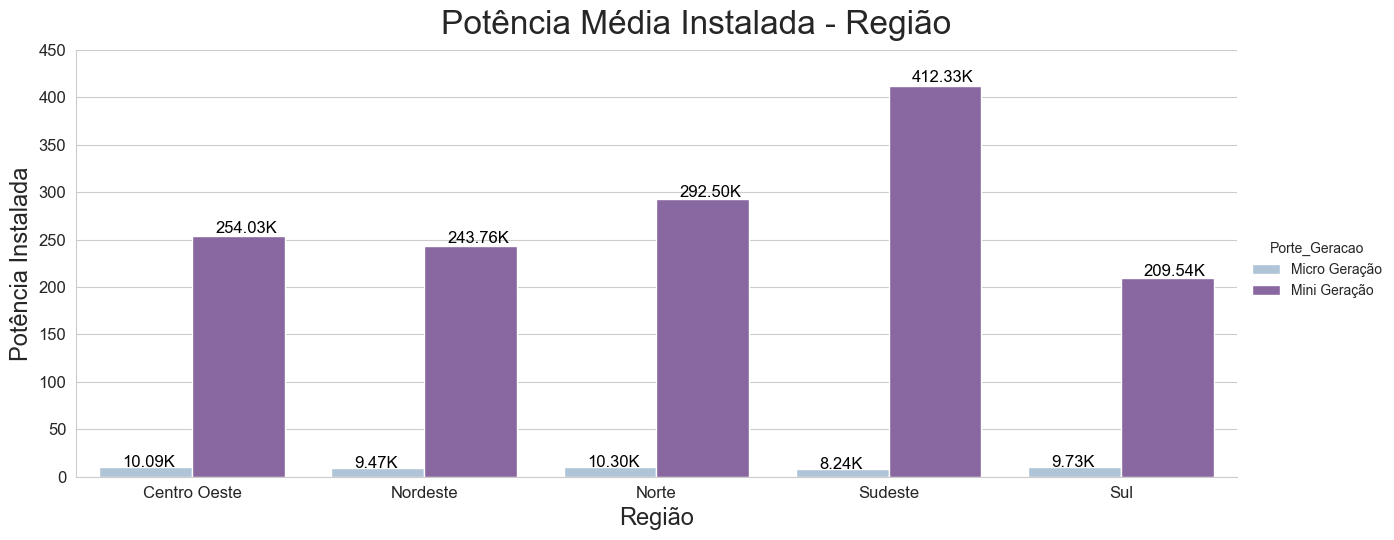

In [68]:
DataFrame = Total_Mini_Micro(Parametro = 'Regiao', Parametro_Opcional_1 = 'Porte_Geracao')

Grafico = sns.catplot(x = 'Regiao', y = 'Pot_Media_por_Unidade', hue = 'Porte_Geracao', kind = 'bar', 
            data = DataFrame, 
            aspect = 2.5, 
            palette = 'BuPu')

Grafico.fig.suptitle('Potência Média Instalada - Região', y = 1.05, fontsize = 24)
Grafico.set_xlabels('Região', fontsize = 17)
Grafico.set_xticklabels(size=12)
Grafico.set_ylabels('Potência Instalada', fontsize = 17)
Grafico.set_yticklabels(size=12)

ax = Grafico.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() +  + 0.1, 
    p.get_height() * 1.01, 
    '{0:.2f}K'.format(p.get_height()),
    color='black', 
    rotation='horizontal', 
    size='large')

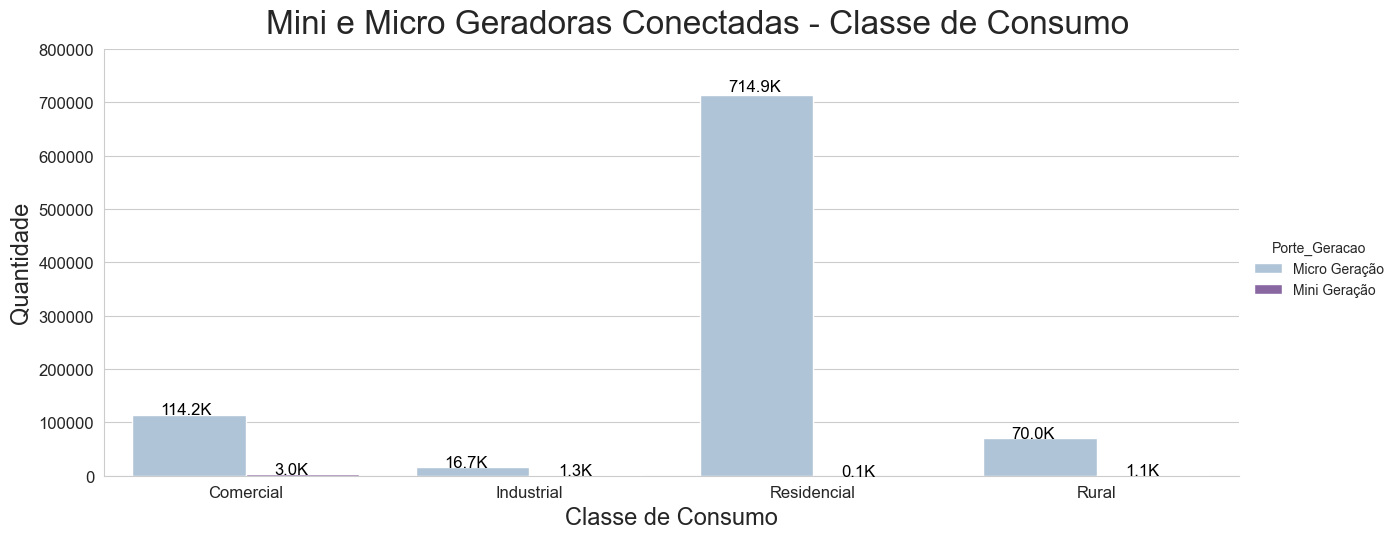

In [62]:
DataFrame = Total_Mini_Micro(Parametro = 'Classe_Consumo', Parametro_Opcional_1 = 'Porte_Geracao')

Grafico = sns.catplot(x = 'Classe_Consumo', y = 'Unidades_Conectadas', hue = 'Porte_Geracao', kind = 'bar', 
            data = DataFrame.query('Classe_Consumo == ["Comercial", "Industrial", "Residencial", "Rural"]'), 
            aspect = 2.5, 
            palette = 'BuPu')

Grafico.fig.suptitle('Mini e Micro Geradoras Conectadas - Classe de Consumo', y = 1.05, fontsize = 24)
Grafico.set_xlabels('Classe de Consumo', fontsize = 17)
Grafico.set_xticklabels(size=12)
Grafico.set_ylabels('Quantidade', fontsize = 17)
Grafico.set_yticklabels(size=12)

ax = Grafico.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() +  + 0.1, 
    p.get_height() * 1.01, 
    '{0:.1f}K'.format(p.get_height()/1000),
    color='black', 
    rotation='horizontal', 
    size='large')

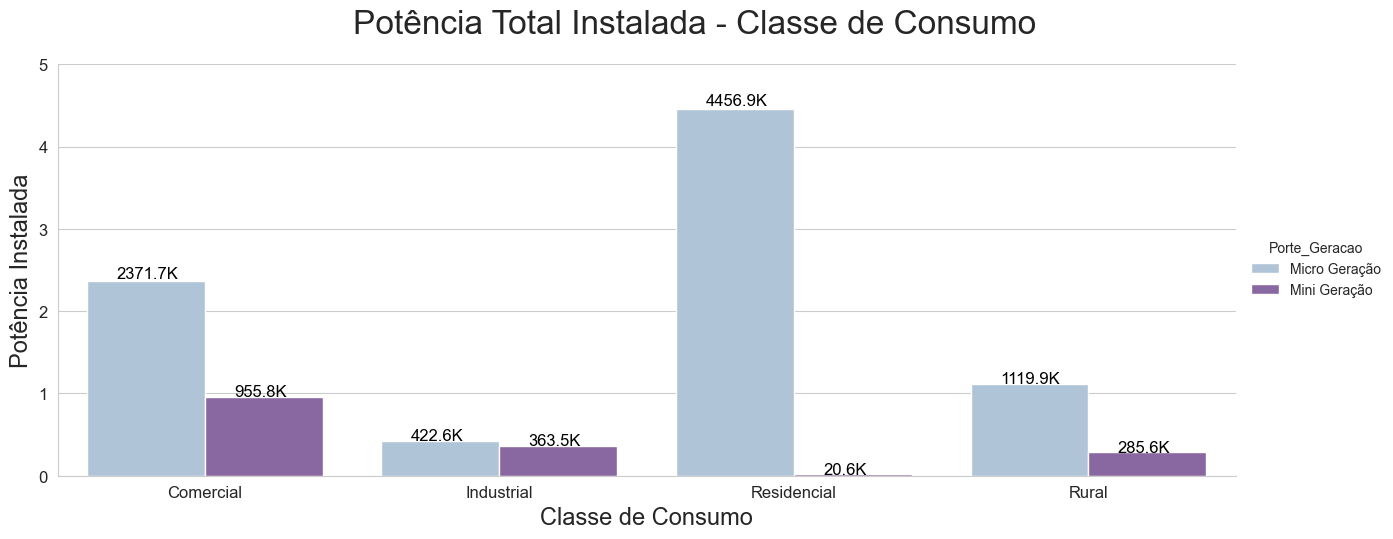

In [63]:
DataFrame = Total_Mini_Micro(Parametro = 'Classe_Consumo', Parametro_Opcional_1 = 'Porte_Geracao')

Grafico = sns.catplot(x = 'Classe_Consumo', y = 'Pot_Instalada_kW', hue = 'Porte_Geracao', kind = 'bar', 
            data = DataFrame.query('Classe_Consumo == ["Comercial", "Industrial", "Residencial", "Rural"]'), 
            aspect = 2.5, 
            palette = 'BuPu')

Grafico.fig.suptitle('Potência Total Instalada - Classe de Consumo', y = 1.05, fontsize = 24)
Grafico.set_xlabels('Classe de Consumo', fontsize = 17)
Grafico.set_xticklabels(size=12)
Grafico.set_ylabels('Potência Instalada', fontsize = 17)
Grafico.set_yticklabels(size=12)

ax = Grafico.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() +  + 0.1, 
    p.get_height() * 1.01, 
    '{0:.1f}K'.format(p.get_height()/1000),
    color='black', 
    rotation='horizontal', 
    size='large')

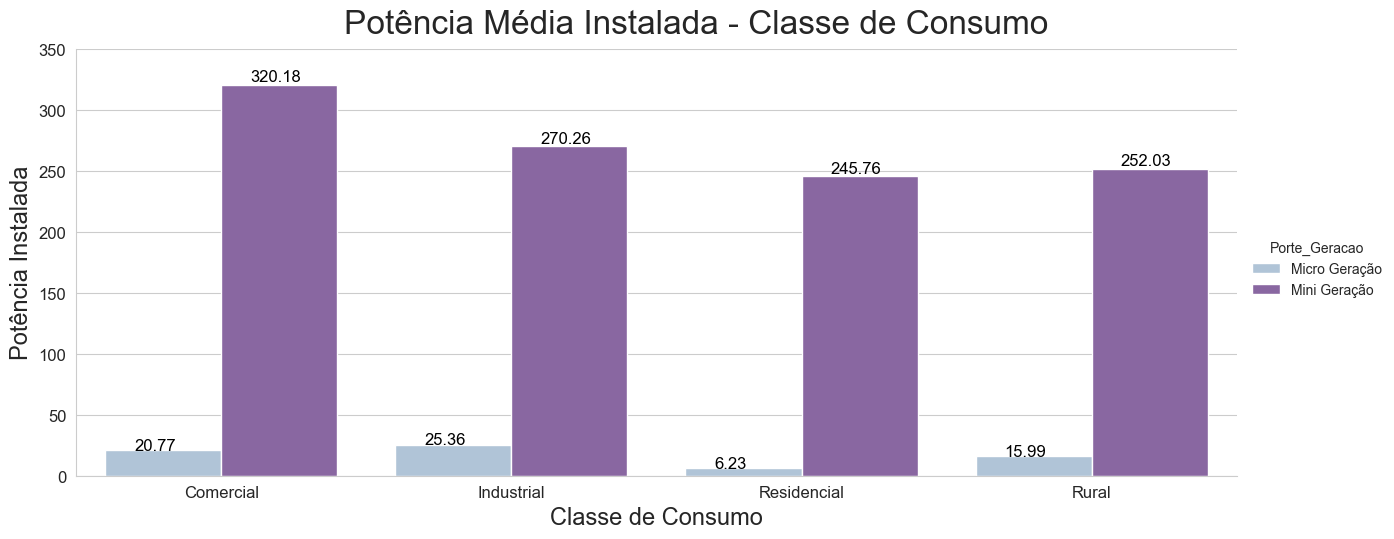

In [67]:
DataFrame = Total_Mini_Micro(Parametro = 'Classe_Consumo', Parametro_Opcional_1 = 'Porte_Geracao')

Grafico = sns.catplot(x = 'Classe_Consumo', y = 'Pot_Media_por_Unidade', hue = 'Porte_Geracao', kind = 'bar', 
            data = DataFrame.query('Classe_Consumo == ["Comercial", "Industrial", "Residencial", "Rural"]'), 
            aspect = 2.5, 
            palette = 'BuPu')

Grafico.fig.suptitle('Potência Média Instalada - Classe de Consumo', y = 1.05, fontsize = 24)
Grafico.set_xlabels('Classe de Consumo', fontsize = 17)
Grafico.set_xticklabels(size=12)
Grafico.set_ylabels('Potência Instalada', fontsize = 17)
Grafico.set_yticklabels(size=12)

ax = Grafico.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() +  + 0.1, 
    p.get_height() * 1.01, 
    '{0:.2f}'.format(p.get_height()),
    color='black', 
    rotation='horizontal', 
    size='large')

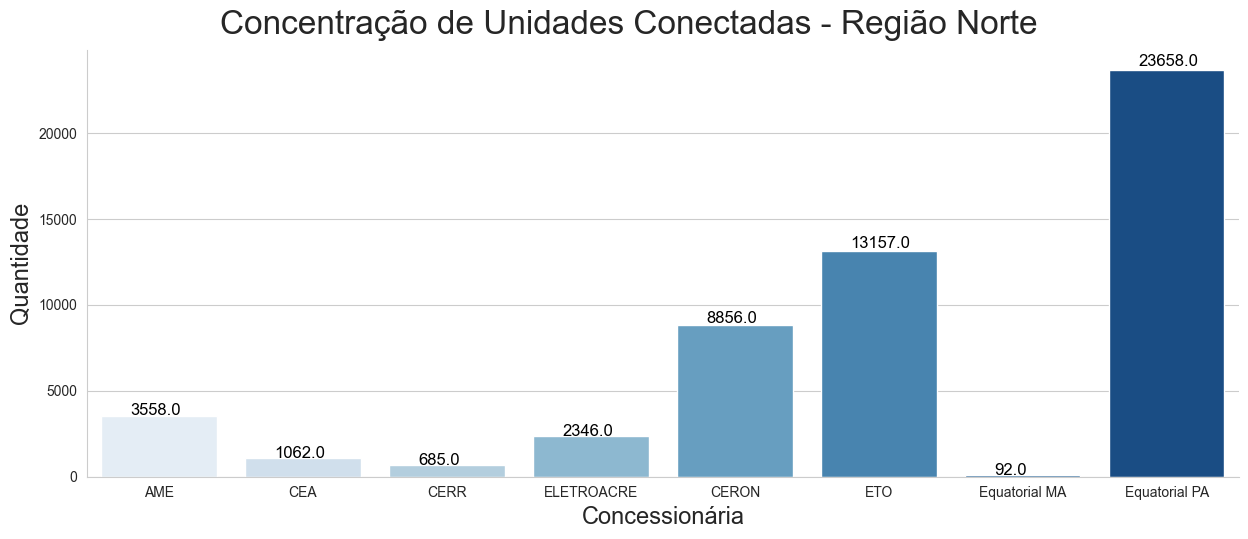

In [82]:
DataFrame = Total_Mini_Micro(Parametro = 'Concessionaria', Parametro_Opcional_1 = 'Sigla', Filtro = 'Regiao == "Norte"')

Grafico = sns.catplot(x = 'Sigla', y = 'Unidades_Conectadas', kind = 'bar', 
            data = DataFrame.query('Unidades_Conectadas >= 50'), 
            aspect = 2.5, 
            palette = 'Blues')

Grafico.fig.suptitle('Concentração de Unidades Conectadas - Região Norte', y = 1.05, fontsize = 24)
Grafico.set_xlabels('Concessionária', fontsize = 17)
Grafico.set_ylabels('Quantidade', fontsize = 17)

ax = Grafico.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() +  + 0.2, 
    p.get_height() * 1.01, 
    '{}'.format(p.get_height()),
    color='black', 
    rotation='horizontal', 
    size='large')

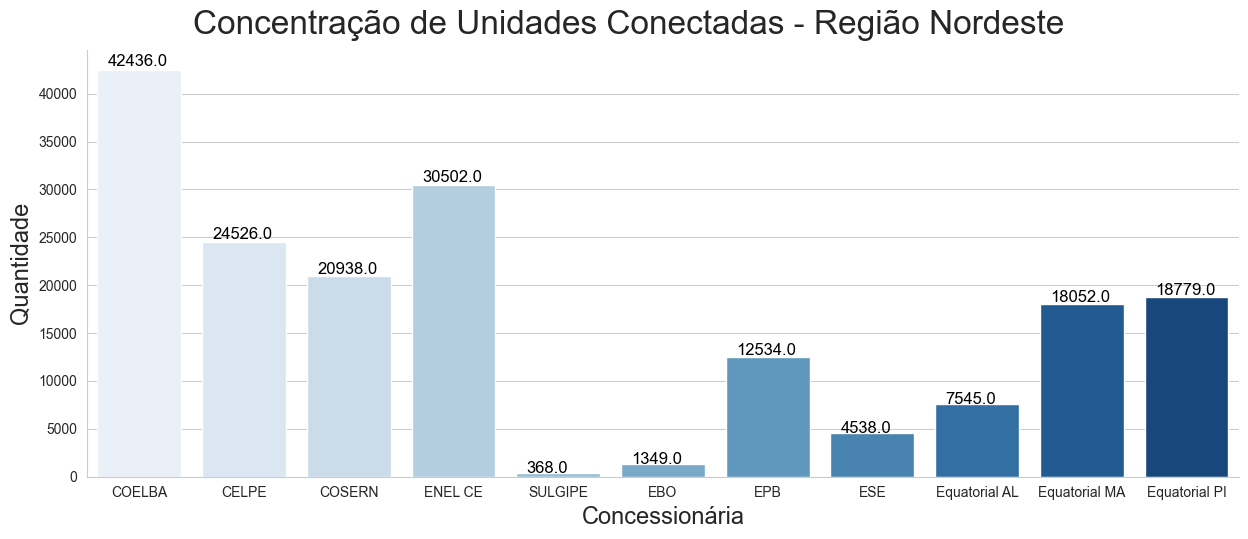

In [83]:
DataFrame = Total_Mini_Micro(Parametro = 'Concessionaria', Parametro_Opcional_1 = 'Sigla', Filtro = 'Regiao == "Nordeste"')

Grafico = sns.catplot(x = 'Sigla', y = 'Unidades_Conectadas', kind = 'bar', 
            data = DataFrame.query('Unidades_Conectadas >= 100'), 
            aspect = 2.5, 
            palette = 'Blues')

Grafico.fig.suptitle('Concentração de Unidades Conectadas - Região Nordeste', y = 1.05, fontsize = 24)
Grafico.set_xlabels('Concessionária', fontsize = 17)
Grafico.set_ylabels('Quantidade', fontsize = 17)

ax = Grafico.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() +  + 0.1, 
    p.get_height() * 1.01, 
    '{}'.format(p.get_height()),
    color='black', 
    rotation='horizontal', 
    size='large')

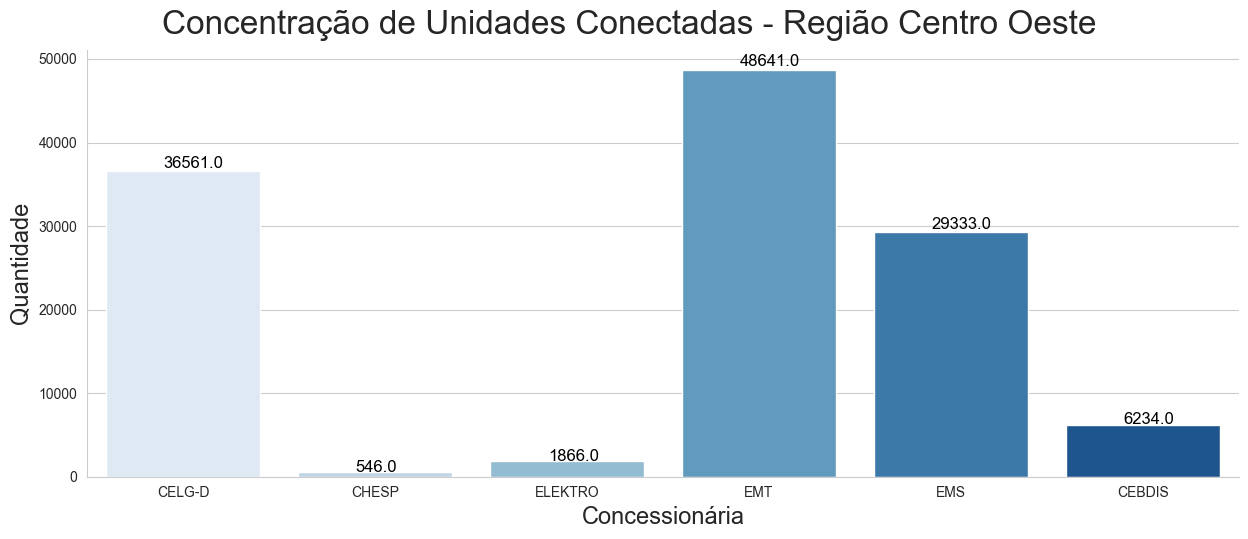

In [84]:
DataFrame = Total_Mini_Micro(Parametro = 'Concessionaria', Parametro_Opcional_1 = 'Sigla', Filtro = 'Regiao == "Centro Oeste"')

Grafico = sns.catplot(x = 'Sigla', y = 'Unidades_Conectadas', kind = 'bar', 
            data = DataFrame.query('Unidades_Conectadas >= 50'), 
            aspect = 2.5, 
            palette = 'Blues')

Grafico.fig.suptitle('Concentração de Unidades Conectadas - Região Centro Oeste', y = 1.05, fontsize = 24)
Grafico.set_xlabels('Concessionária', fontsize = 17)
Grafico.set_ylabels('Quantidade', fontsize = 17)

ax = Grafico.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() +  + 0.3, 
    p.get_height() * 1.01, 
    '{}'.format(p.get_height()),
    color='black', 
    rotation='horizontal', 
    size='large')

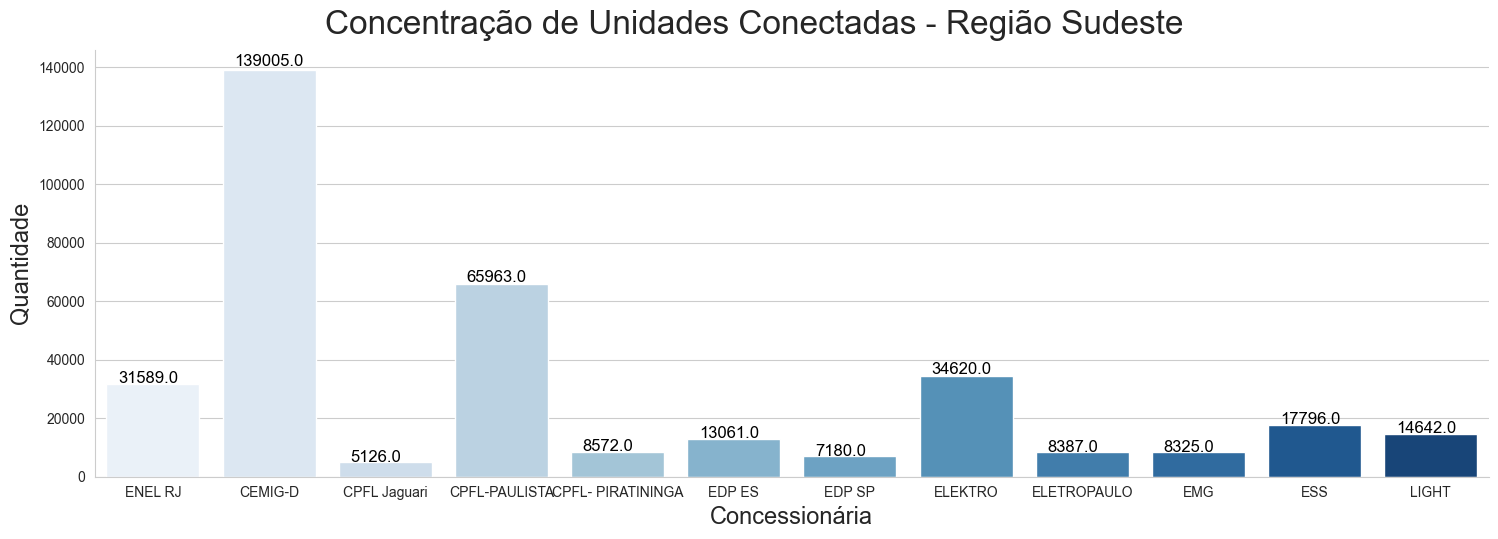

In [85]:
DataFrame = Total_Mini_Micro(Parametro = 'Concessionaria', Parametro_Opcional_1 = 'Sigla', Filtro = 'Regiao == "Sudeste"')

Grafico = sns.catplot(x = 'Sigla', y = 'Unidades_Conectadas', kind = 'bar', 
            data = DataFrame.query('Unidades_Conectadas >= 2000'), 
            aspect = 3, 
            palette = 'Blues')

Grafico.fig.suptitle('Concentração de Unidades Conectadas - Região Sudeste', y = 1.05, fontsize = 24)
Grafico.set_xlabels('Concessionária', fontsize = 17)
Grafico.set_ylabels('Quantidade', fontsize = 17)

ax = Grafico.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() +  + 0.1, 
    p.get_height() * 1.01, 
    '{}'.format(p.get_height()),
    color='black', 
    rotation='horizontal', 
    size='large')

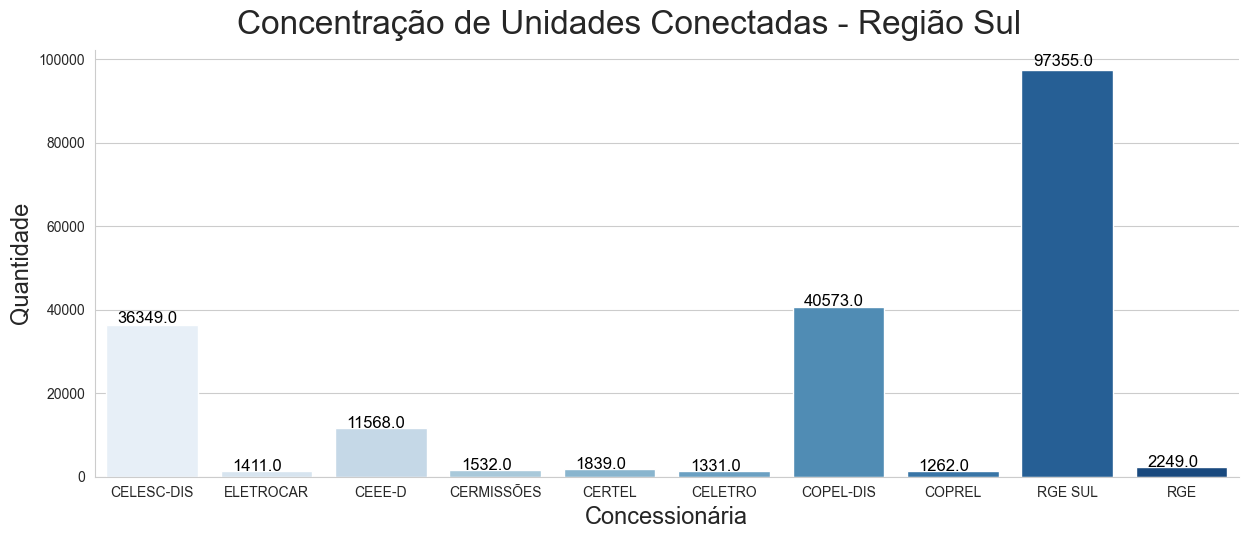

In [86]:
DataFrame = Total_Mini_Micro(Parametro = 'Concessionaria', Parametro_Opcional_1 = 'Sigla', Filtro = 'Regiao == "Sul"')

Grafico = sns.catplot(x = 'Sigla', y = 'Unidades_Conectadas', kind = 'bar', 
            data = DataFrame.query('Unidades_Conectadas >= 1000'), 
            aspect = 2.5, 
            palette = 'Blues')

Grafico.fig.suptitle('Concentração de Unidades Conectadas - Região Sul', y = 1.05, fontsize = 24)
Grafico.set_xlabels('Concessionária', fontsize = 17)
Grafico.set_ylabels('Quantidade', fontsize = 17)

ax = Grafico.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() +  + 0.1, 
    p.get_height() * 1.01, 
    '{}'.format(p.get_height()),
    color='black', 
    rotation='horizontal', 
    size='large')

###  **3.2 Séries Temporais**

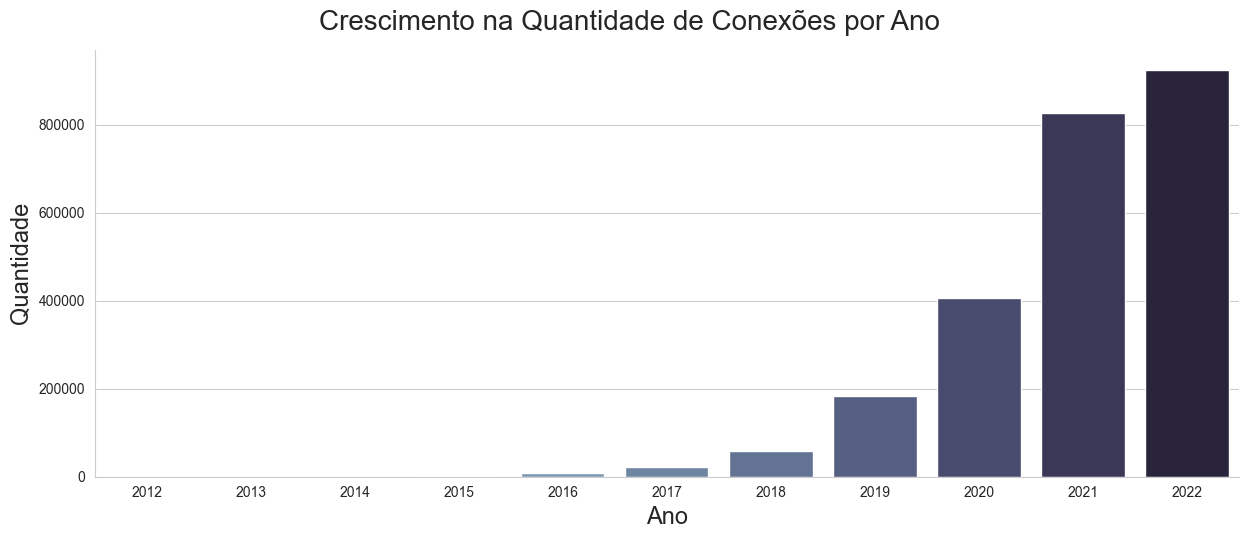

In [81]:
DataFrame = Frequencia_Relativa('Regiao').groupby('Ano', as_index = False)['Novas_Conexoes', 'Acumulado'].sum()

Grafico = sns.catplot(x = 'Ano', y = 'Acumulado', kind = 'bar',
            data = DataFrame.query('Ano >= 2012'), 
            aspect = 2.5,
            palette = 'ch:start=.2,rot=-.3')

Grafico.fig.suptitle('Crescimento na Quantidade de Conexões por Ano', y = 1.05, fontsize = 20)
Grafico.set_xlabels('Ano', fontsize = 17)
Grafico.set_ylabels('Quantidade', fontsize = 17)

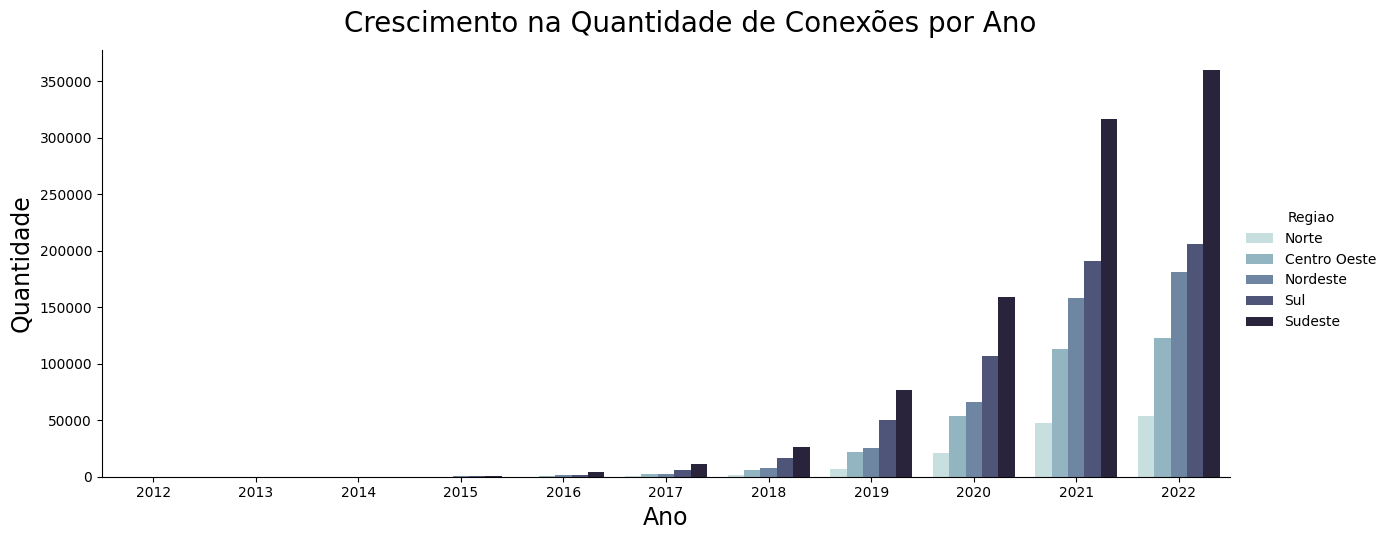

In [17]:
DataFrame = Frequencia_Relativa('Regiao')
DataFrame['Regiao'] = pd.Categorical(DataFrame['Regiao'], ['Norte','Centro Oeste','Nordeste','Sul', 'Sudeste'])

Grafico = sns.catplot(x = 'Ano', y = 'Acumulado', hue = 'Regiao', kind = 'bar',
            data = DataFrame.query('Ano >= 2012'), 
            aspect = 2.5,
            palette = 'ch:start=.2,rot=-.3')

Grafico.fig.suptitle('Crescimento na Quantidade de Conexões por Ano', y = 1.05, fontsize = 20)
Grafico.set_xlabels('Ano', fontsize = 17)
Grafico.set_ylabels('Quantidade', fontsize = 17)

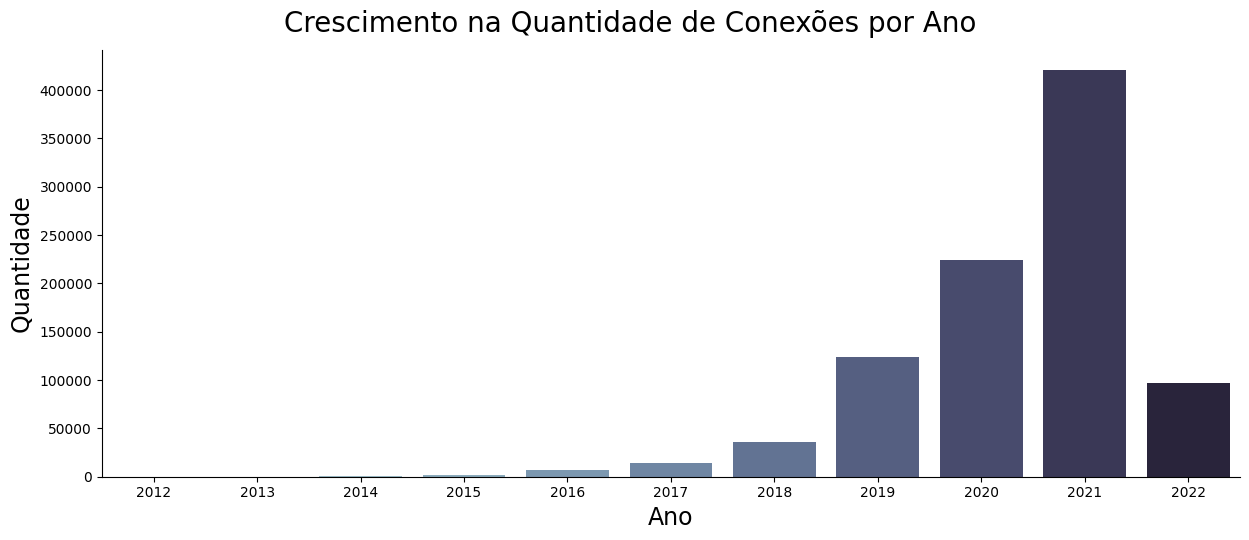

In [18]:
DataFrame = Frequencia_Relativa('Regiao').groupby('Ano', as_index = False)['Novas_Conexoes', 'Acumulado'].sum()

Grafico = sns.catplot(x = 'Ano', y = 'Novas_Conexoes', kind = 'bar',
            data = DataFrame.query('Ano >= 2012'), 
            aspect = 2.5,
            palette = 'ch:start=.2,rot=-.3')

Grafico.fig.suptitle('Crescimento na Quantidade de Conexões por Ano', y = 1.05, fontsize = 20)
Grafico.set_xlabels('Ano', fontsize = 17)
Grafico.set_ylabels('Quantidade', fontsize = 17)

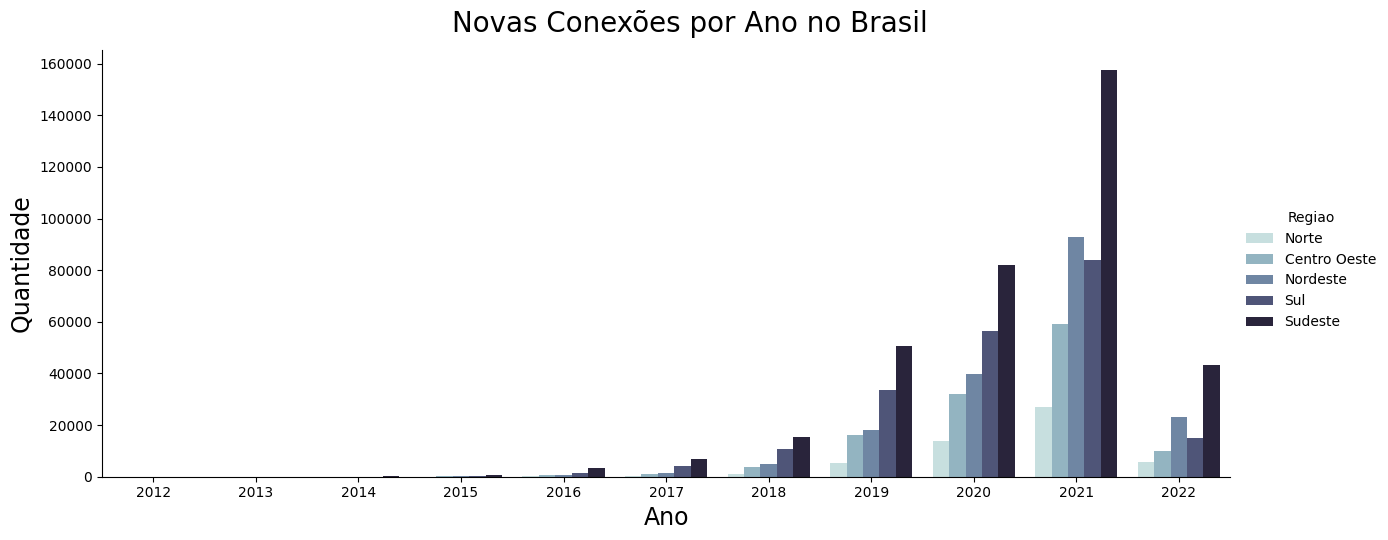

In [19]:
DataFrame = Frequencia_Relativa('Regiao')
DataFrame['Regiao'] = pd.Categorical(DataFrame['Regiao'], ['Norte','Centro Oeste','Nordeste','Sul', 'Sudeste'])

Grafico = sns.catplot(x = 'Ano', y = 'Novas_Conexoes', hue = 'Regiao', kind = 'bar',
            data = DataFrame.query('Ano >= 2012'), 
            aspect = 2.5,
            palette = 'ch:start=.2,rot=-.3')

Grafico.fig.suptitle('Novas Conexões por Ano no Brasil', y = 1.05, fontsize = 20)
Grafico.set_xlabels('Ano', fontsize = 17)
Grafico.set_ylabels('Quantidade', fontsize = 17)

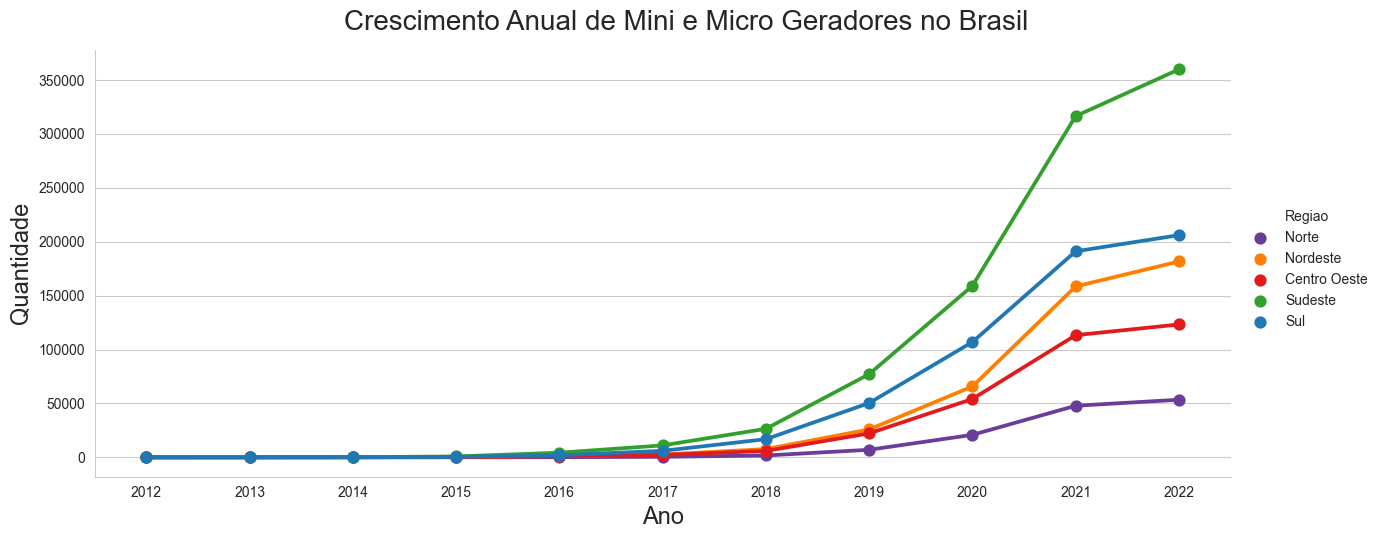

In [54]:
DataFrame = Frequencia_Relativa('Regiao')
DataFrame['Regiao'] = pd.Categorical(DataFrame['Regiao'], 
['Norte', 'Nordeste', 'Centro Oeste', 'Sudeste', 'Sul'])

Grafico = sns.catplot(x = 'Ano', y = 'Acumulado', hue = "Regiao", kind = 'point',
            data = DataFrame.query('Ano >= 2012'), 
            aspect = 2.5,
            palette = 'Paired_r')

Grafico.fig.suptitle('Crescimento Anual de Mini e Micro Geradores no Brasil', y = 1.05, fontsize = 20)
Grafico.set_xlabels('Ano', fontsize = 17)
Grafico.set_ylabels('Quantidade', fontsize = 17)

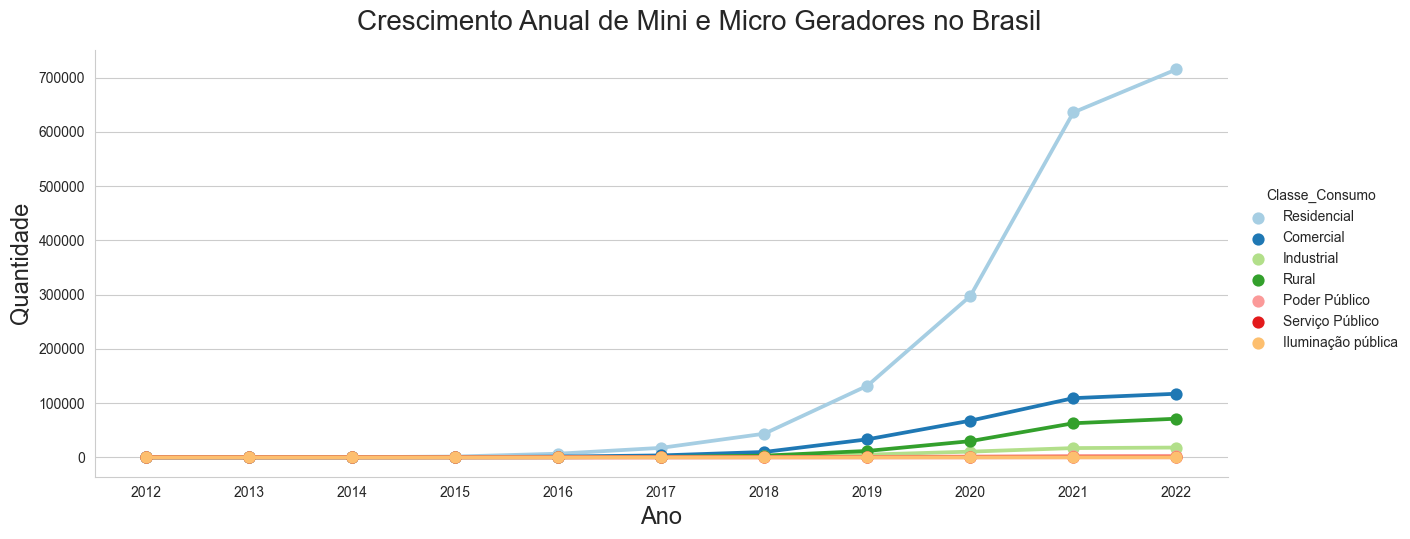

In [53]:
DataFrame = Frequencia_Relativa('Classe_Consumo')
DataFrame['Classe_Consumo'] = pd.Categorical(DataFrame['Classe_Consumo'], 
['Residencial', 'Comercial', 'Industrial', 'Rural', 'Poder Público', 'Serviço Público', 'Iluminação pública'])

Grafico = sns.catplot(x = 'Ano', y = 'Acumulado', hue = "Classe_Consumo", kind = 'point',
            data = DataFrame.query('Ano >= 2012'), 
            aspect = 2.5,
            palette = 'Paired')

Grafico.fig.suptitle('Crescimento Anual de Mini e Micro Geradores no Brasil', y = 1.05, fontsize = 20)
Grafico.set_xlabels('Ano', fontsize = 17)
Grafico.set_ylabels('Quantidade', fontsize = 17)

###  **3.3 Potência Instalada**

<AxesSubplot:title={'center':'Potência Média Instalada po Tipo de Geração'}, xlabel='kW', ylabel='Tipo de Unidade Geradora'>

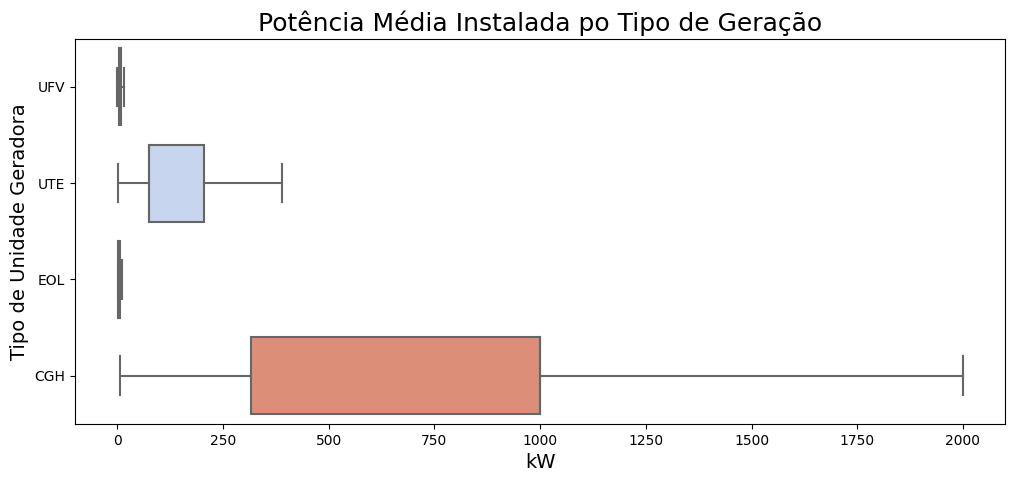

In [20]:
Grafico = sns.boxplot(x = 'Pot_Instalada_kW', y = 'Tipo_Geracao', 
                 data = df_Base.query('Data_Conexao.dt.year >= 2012'), 
                 orient = 'h',
                 showfliers = False,
                 palette = 'coolwarm')
Grafico.figure.set_size_inches(12,5)
Grafico.set_title('Potência Média Instalada po Tipo de Geração', fontsize=18)
Grafico.set_xlabel('kW', fontsize=14)
Grafico.set_ylabel('Tipo de Unidade Geradora', fontsize=14)
Grafico

> O Art. 2º do Capítulo I da Resolução Normativa 482/2012 da ANEEL estabelece que **Microgeração Distribuída** são centrais geradoras com potência instalada menor ou igual a 75 kW, enquanto **Minigeração Distribuída** são as centrais geradoras com potência instalada superior a 75kW e com limite superior de 5MW (5.000 kW).
>
> Considerando os intervalos estabelecidos pela REN 482/2012, O Boxplot acima evidência a tendência a potência instalada pelo tipo de unidade geradora adotada.  
>
> É possível observar que a compressão dos boxplot referentes a unidades de geração fotovoltaica e eólica em valores muito baixos indicam que a tendência para esse tipo de geração ocorre na faixa que compreende o intervalor de unidades de microgeração, até 75 kW, e sua representatividade na faixa que compreende minigeradoras ocorre devido a dados discrepantes (outliers). 
>
> Unidades geradoras do tipo termoelétrica (UTE) e hidrelétrica (CGH) apresentam tendência no intervalor que compreende minigeradoras.

<AxesSubplot:title={'center':'Potência Média de Microgeradoras Fotovoltaíca e Eólica'}, xlabel='kW', ylabel='Tipo de Unidade Geradora'>

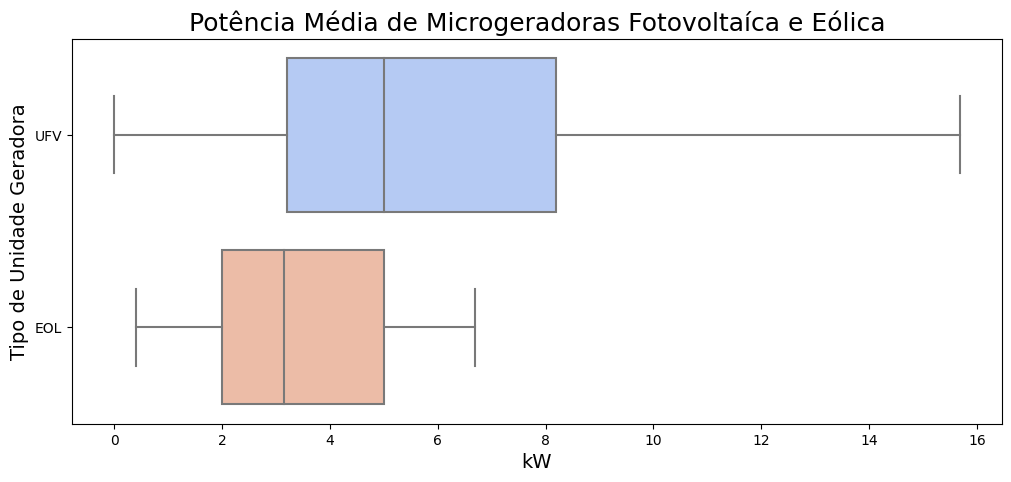

In [21]:
Grafico = sns.boxplot(x = 'Pot_Instalada_kW', y = 'Tipo_Geracao', 
                 data = df_Base.query('Data_Conexao.dt.year >= 2012 and Pot_Instalada_kW <= 75 and Tipo_Geracao == ["UFV", "EOL"]'),
                 orient = 'h',
                 showfliers=False,
                 palette = 'coolwarm')
Grafico.figure.set_size_inches(12,5)
Grafico.set_title('Potência Média de Microgeradoras Fotovoltaíca e Eólica', fontsize=18)
Grafico.set_xlabel('kW', fontsize=14)
Grafico.set_ylabel('Tipo de Unidade Geradora', fontsize=14)
Grafico

> Restringindo os parâmetros para unidades de microgeração do tipo fotovoltaica e observando o comportamento das 4 princípais classes de consumo obtêm-se o seguinte gráfico:

<AxesSubplot:title={'center':'Potência Média Instalada de Geradoras Fotovoltaica'}, xlabel='kW', ylabel='Classe de Consumo'>

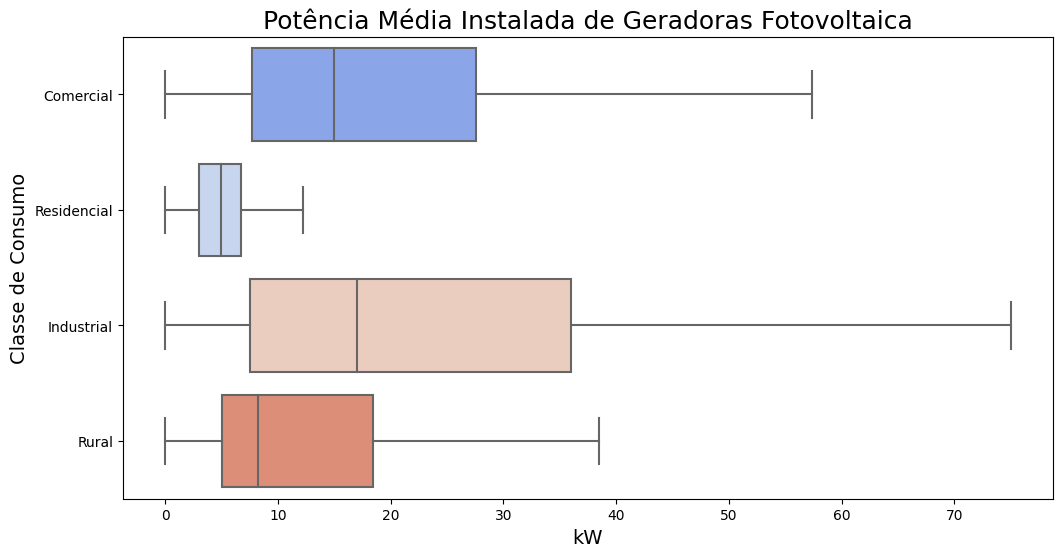

In [22]:
Grafico = sns.boxplot(x = 'Pot_Instalada_kW', y = 'Classe_Consumo',
                 data = df_Base.query('Data_Conexao.dt.year >= 2012 and Pot_Instalada_kW <= 75 and Tipo_Geracao == "UFV" and Classe_Consumo == ["Residencial", "Comercial", "Industrial", "Rural"]'), 
                 orient = 'h',
                 showfliers=False,
                 palette = 'coolwarm')
Grafico.figure.set_size_inches(12,6)
Grafico.set_title('Potência Média Instalada de Geradoras Fotovoltaica', fontsize=18)
Grafico.set_xlabel('kW', fontsize=14)
Grafico.set_ylabel('Classe de Consumo', fontsize=14)
Grafico

In [23]:
print('Medianas do Boxplot: \n \nResidencial: %s kW\nComercial: %s kW\nRural: %s kW\nIndustrial: %s kW' % 
      (Mediana_Pot("Residencial"), Mediana_Pot("Comercial"), Mediana_Pot("Rural"), Mediana_Pot("Industrial")))

Medianas do Boxplot: 
 
Residencial: 4.92 kW
Comercial: 15.0 kW
Rural: 8.2 kW
Industrial: 17.0 kW


<AxesSubplot:title={'center':'Potência Média Instalada de Geradoras Fotovoltaica'}, xlabel='kW', ylabel='Classe de Consumo'>

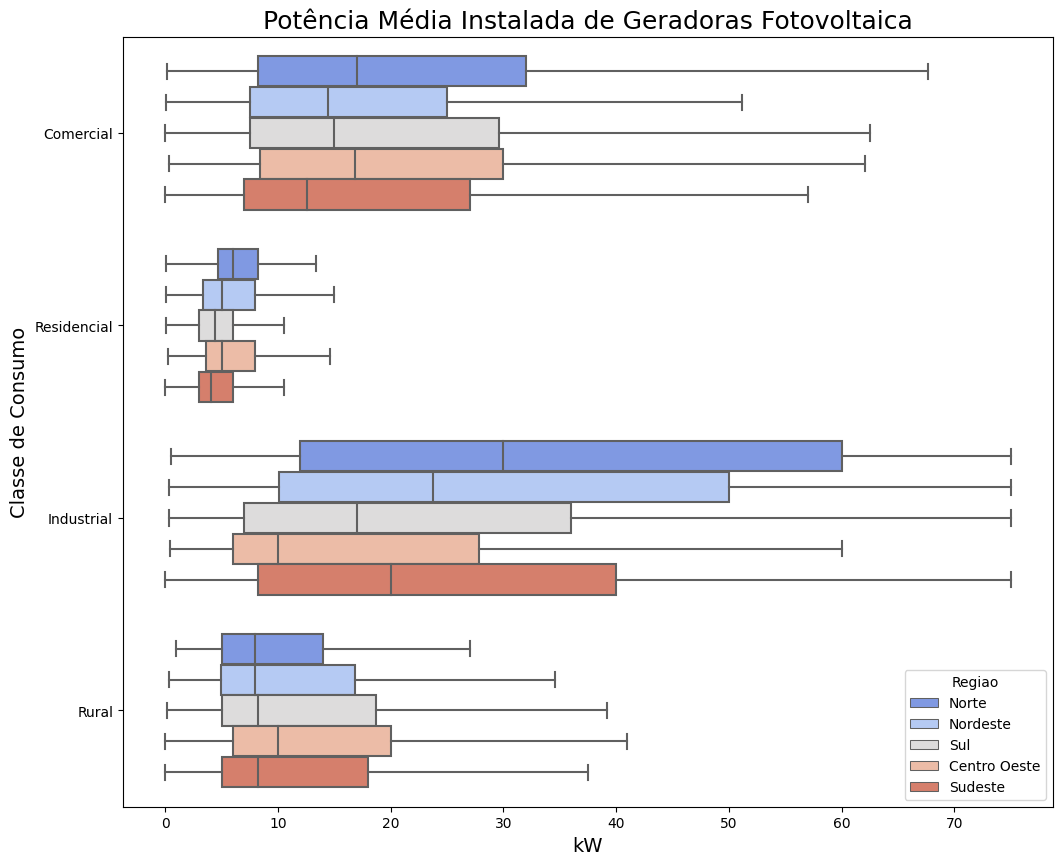

In [24]:
Grafico = sns.boxplot(x = 'Pot_Instalada_kW', y = 'Classe_Consumo', hue = 'Regiao',
                 data = df_Base.query('Data_Conexao.dt.year >= 2012 and Pot_Instalada_kW <= 75 and Tipo_Geracao == "UFV" and Classe_Consumo == ["Residencial", "Comercial", "Industrial", "Rural"]'), 
                 orient = 'h',
                 showfliers=False,
                 palette = 'coolwarm')
Grafico.figure.set_size_inches(12,10)
Grafico.set_title('Potência Média Instalada de Geradoras Fotovoltaica', fontsize=18)
Grafico.set_xlabel('kW', fontsize=14)
Grafico.set_ylabel('Classe de Consumo', fontsize=14)
Grafico

###  **3.4 Frequência Relativa**

<AxesSubplot:title={'center':'Frequência Relativa do Total de Conexões por Região'}, xlabel='Ano', ylabel='Percentual [%]'>

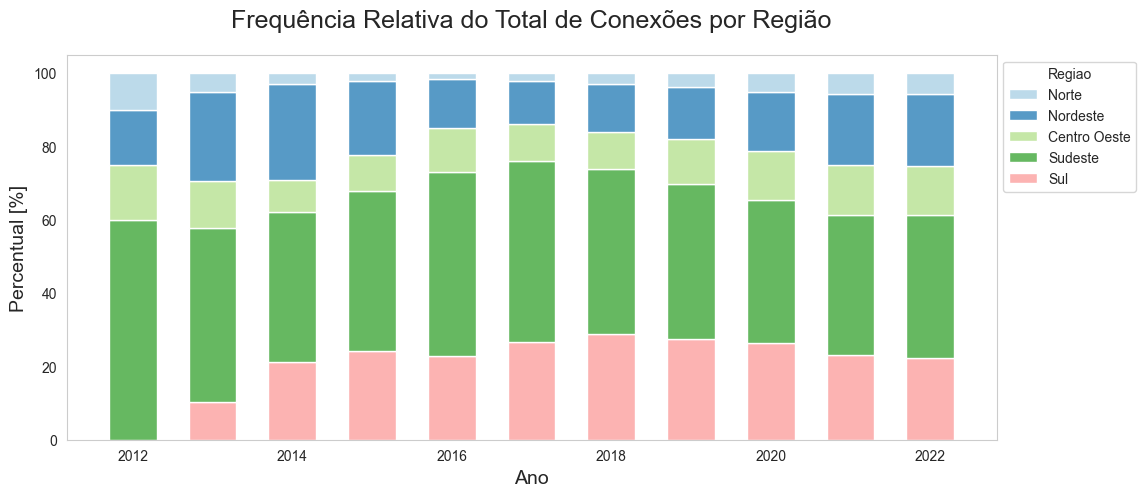

In [43]:
DataFrame = Frequencia_Relativa('Regiao')
DataFrame['Regiao'] = pd.Categorical(DataFrame['Regiao'], ['Norte','Nordeste','Centro Oeste','Sudeste', 'Sul'])

Grafico = sns.histplot(x = 'Ano' , 
    hue = 'Regiao', 
    weights = 'Freq_Acumulado[%]',
    multiple = 'stack',
    data = DataFrame.query('Ano >= 2012'),
    palette = 'Paired',
    shrink = 0.6,
    binwidth = 1,
    discrete = True, # Alinha os pontos aos dados.
    bins = 10)

Grafico.figure.set_size_inches(12,5)
Grafico.set_title('Frequência Relativa do Total de Conexões por Região', y = 1.05, fontsize = 18)
Grafico.set_xlabel('Ano', fontsize = 14)
Grafico.set_ylabel('Percentual [%]', fontsize = 14)
Grafico.grid(False)
move_legend(Grafico, 'upper left', bbox_to_anchor=(1, 1))
Grafico

<AxesSubplot:title={'center':'Frequência Relativa do Total de Conexões por Classe de Consumo'}, xlabel='Ano', ylabel='Percentual [%]'>

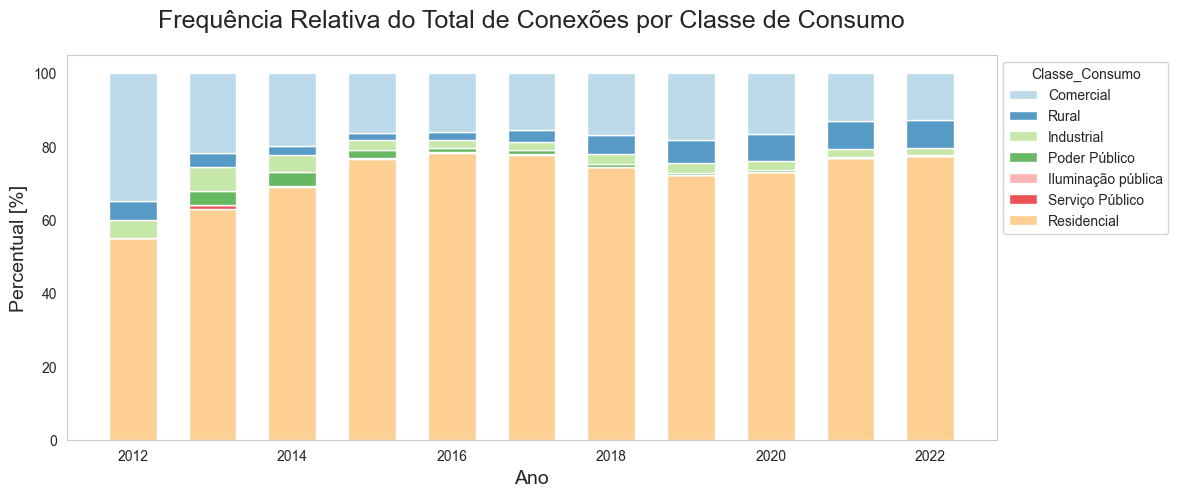

In [47]:
DataFrame = Frequencia_Relativa('Classe_Consumo')
DataFrame['Classe_Consumo'] = pd.Categorical(DataFrame['Classe_Consumo'], 
['Comercial', 'Rural', 'Industrial', 'Poder Público', 'Iluminação pública', 'Serviço Público', 'Residencial'])

Grafico = sns.histplot(x = 'Ano' , 
    hue = 'Classe_Consumo', 
    weights = 'Freq_Acumulado[%]',
    multiple = 'stack',
    data = DataFrame.query('Ano >= 2012'), #and Classe_Consumo == ["Comercial", "Residencial", "Industrial", "Rural"]
    palette = 'Paired',
    shrink = 0.6,
    binwidth = 1,
    discrete = True, # Alinha os pontos aos dados.
    bins = 10)

Grafico.figure.set_size_inches(12,5)
Grafico.set_title('Frequência Relativa do Total de Conexões por Classe de Consumo', y = 1.05, fontsize = 18)
Grafico.set_xlabel('Ano', fontsize = 14)
Grafico.set_ylabel('Percentual [%]', fontsize = 14)
Grafico.grid(False)
move_legend(Grafico, 'upper left', bbox_to_anchor=(1, 1))
Grafico

###  **3.5 Evolução da Tarifa**

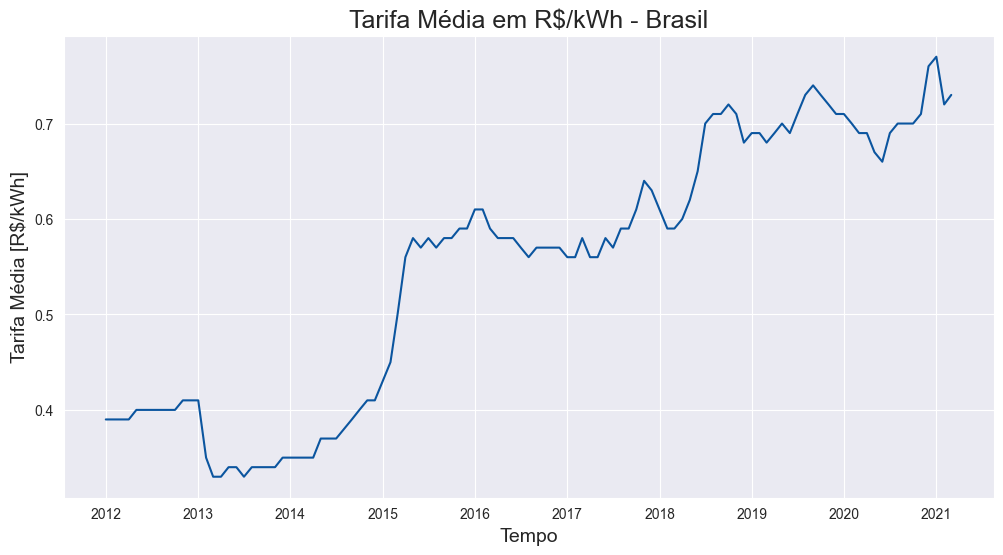

In [25]:
sns.set_palette('Blues_r')
sns.set_style('darkgrid')
Tarifa_Comparacao = sns.lineplot(x = 'Data_Referencia', 
                             y = 'Tarifa_Tributada_R$',
                             data = df_Tarifas.query('Regiao == "Brasil"')
                             ) 
Tarifa_Comparacao.figure.set_size_inches(12,6)
Tarifa_Comparacao.set_title('Tarifa Média em R$/kWh - Brasil', loc='center', fontsize=18)
Tarifa_Comparacao.set_xlabel('Tempo', fontsize=14)
Tarifa_Comparacao.set_ylabel('Tarifa Média [R$/kWh]', fontsize=14)
Tarifa_Comparacao = Tarifa_Comparacao